In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tdc.multi_pred import DTI
import seaborn as sns
import pickle

### Loading Datasets

In [3]:
# Davis dataset
data = DTI(name='Davis')
data.convert_to_log(form = 'binding')
df = data.get_data()
unique_drugs = df['Drug'].unique()
unique_targets = df['Target'].unique()
print('Davis: Ligands:'+str(len(unique_drugs))+ ' Proteins:'+str(len(unique_targets)))

# Binding DB dataset
data = DTI(name='BindingDB_Kd')
data.convert_to_log(form = 'binding')
df1 = data.get_data()
unique_drugs1 = df1['Drug'].unique()
unique_targets1 = df1['Target'].unique()
print('BindingDB: Ligands:'+str(len(unique_drugs1))+ ' Proteins:'+str(len(unique_targets1)))


Found local copy...
Loading...
Done!
To log space...
Downloading...


Davis: Ligands:68 Proteins:379


100%|█████████████████████████████████████| 54.4M/54.4M [00:16<00:00, 3.38MiB/s]
Loading...
Done!
To log space...


BindingDB: Ligands:10661 Proteins:1413


In [5]:
df.columns

Index(['Drug_ID', 'Drug', 'Target_ID', 'Target', 'Y'], dtype='object')

### Scaffold Splitting

In [12]:

import os, sys
import numpy as np
import pandas as pd
from tqdm import tqdm
# from .misc import print_sys


def create_fold(df, fold_seed, frac):
    """create random split

    Args:
        df (pd.DataFrame): dataset dataframe
        fold_seed (int): the random seed
        frac (list): a list of train/valid/test fractions

    Returns:
        dict: a dictionary of splitted dataframes, where keys are train/valid/test and values correspond to each dataframe
    """
    train_frac, val_frac, test_frac = frac
    test = df.sample(frac=test_frac, replace=False, random_state=fold_seed)
    train_val = df[~df.index.isin(test.index)]
    val = train_val.sample(
        frac=val_frac / (1 - test_frac), replace=False, random_state=1
    )
    train = train_val[~train_val.index.isin(val.index)]

    return {
        "train": train.reset_index(drop=True),
        "valid": val.reset_index(drop=True),
        "test": test.reset_index(drop=True),
    }


def create_scaffold_split_dti(df, seed, frac, drug_column):
    """
    Create scaffold split for drug-target interaction data. 
    It first generates molecular scaffold for each drug molecule 
    and then split based on scaffolds while considering the drug-target pairs.

    Args:
        df (pd.DataFrame): dataset dataframe with drug-target interactions
        seed (int): the random seed
        frac (list): a list of train/valid/test fractions
        drug_column (str): the column name where drug molecules (SMILES) are stored

    Returns:
        dict: a dictionary of split dataframes (train/valid/test)
    """
    from rdkit import Chem
    from rdkit.Chem.Scaffolds import MurckoScaffold
    from random import Random
    from collections import defaultdict

    random = Random(seed)

    # Generate scaffolds for each drug
    scaffolds = defaultdict(set)
    for idx, row in df.iterrows():
        smiles = row[drug_column]
        try:
            mol = Chem.MolFromSmiles(smiles)
            scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=False)
            scaffolds[scaffold].add(idx)
        except:
            continue

    # Split scaffolds into train, valid, test sets
    scaffolds = list(scaffolds.values())
    random.shuffle(scaffolds)

    train_size = int(len(df) * frac[0])
    valid_size = int(len(df) * frac[1])

    train, valid, test = set(), set(), set()
    for scaffold_set in scaffolds:
        if len(train) + len(scaffold_set) <= train_size:
            train.update(scaffold_set)
        elif len(valid) + len(scaffold_set) <= valid_size:
            valid.update(scaffold_set)
        else:
            test.update(scaffold_set)

    # Create DataFrame subsets for each split
    train_df = df.iloc[list(train)].reset_index(drop=True)
    valid_df = df.iloc[list(valid)].reset_index(drop=True)
    test_df = df.iloc[list(test)].reset_index(drop=True)

    return{
        "train": train_df.reset_index(drop=True),
        "valid": valid_df.reset_index(drop=True),
        "test": test_df.reset_index(drop=True),
    }




In [11]:
seed = 42 
frac = [0.7, 0.2, 0.1]  


scaffold_split_davis = create_scaffold_split_dti(df, seed, frac, 'Drug')

scaffold_split_bindingdb = create_scaffold_split_dti(df1, seed, frac, 'Drug')


train_davis = scaffold_split_davis['train']
valid_davis = scaffold_split_davis['valid']
test_davis = scaffold_split_davis['test']

train_bindingdb = scaffold_split_bindingdb['train']
valid_bindingdb = scaffold_split_bindingdb['valid']
test_bindingdb = scaffold_split_bindingdb['test']


print("Davis Dataset Splits:")
print("Train:", len(train_davis), "Valid:", len(valid_davis), "Test:", len(test_davis))

print("BindingDB Dataset Splits:")
print("Train:", len(train_bindingdb), "Valid:", len(valid_bindingdb), "Test:", len(test_bindingdb))


Davis Dataset Splits:
Train: 17813 Valid: 4927 Test: 3032
BindingDB Dataset Splits:
Train: 36591 Valid: 10454 Test: 5229


In [13]:
# Define the create_scaffold_split_dti function here (as provided in the previous response)

# Specify the random seed and the train/valid/test split fractions
seed = 42  # Example seed, can be any integer
frac = [0.7, 0.2, 0.1]  # Example fractions for train, valid, test splits

# Perform scaffold-based split for the Davis dataset
scaffold_split_davis = create_scaffold_split_dti(df, seed, frac, 'Drug')

# Perform scaffold-based split for the BindingDB dataset
scaffold_split_bindingdb = create_scaffold_split_dti(df1, seed, frac, 'Drug')

# Access the train, valid, and test splits for each dataset
train_davis = scaffold_split_davis['train']
valid_davis = scaffold_split_davis['valid']
test_davis = scaffold_split_davis['test']

train_bindingdb = scaffold_split_bindingdb['train']
valid_bindingdb = scaffold_split_bindingdb['valid']
test_bindingdb = scaffold_split_bindingdb['test']

# Print out the sizes of each split for verification
print("Davis Dataset Splits:")
print("Train:", len(train_davis), "Valid:", len(valid_davis), "Test:", len(test_davis))

print("BindingDB Dataset Splits:")
print("Train:", len(train_bindingdb), "Valid:", len(valid_bindingdb), "Test:", len(test_bindingdb))


Davis Dataset Splits:
Train: 17813 Valid: 4927 Test: 3032
BindingDB Dataset Splits:
Train: 36591 Valid: 10454 Test: 5229


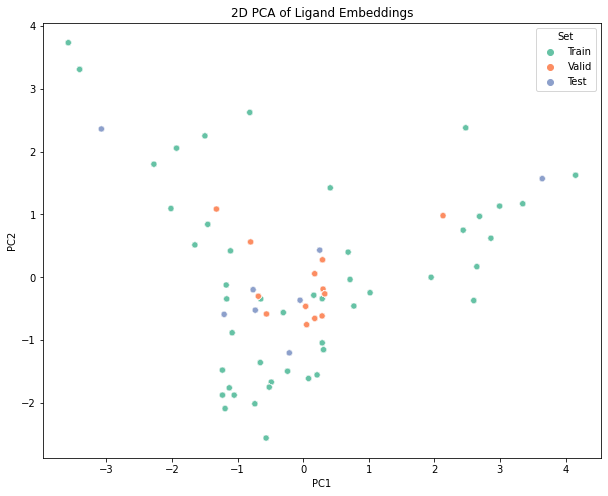

In [15]:
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def get_fingerprints(smiles_list):
    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), radius=2, nBits=1024) for smile in smiles_list]
    np_fps = np.array([list(fp) for fp in fps])
    return np_fps


train_fps = get_fingerprints(train_davis['Drug'])
valid_fps = get_fingerprints(valid_davis['Drug'])
test_fps = get_fingerprints(test_davis['Drug'])


pca = PCA(n_components=2)
train_embeddings = pca.fit_transform(train_fps)
valid_embeddings = pca.transform(valid_fps)
test_embeddings = pca.transform(test_fps)


df_plot = pd.DataFrame(np.vstack([train_embeddings, valid_embeddings, test_embeddings]), columns=['PC1', 'PC2'])
df_plot['Set'] = ['Train'] * len(train_embeddings) + ['Valid'] * len(valid_embeddings) + ['Test'] * len(test_embeddings)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Set', palette='Set2')
plt.title('2D PCA of Ligand Embeddings')
plt.show()


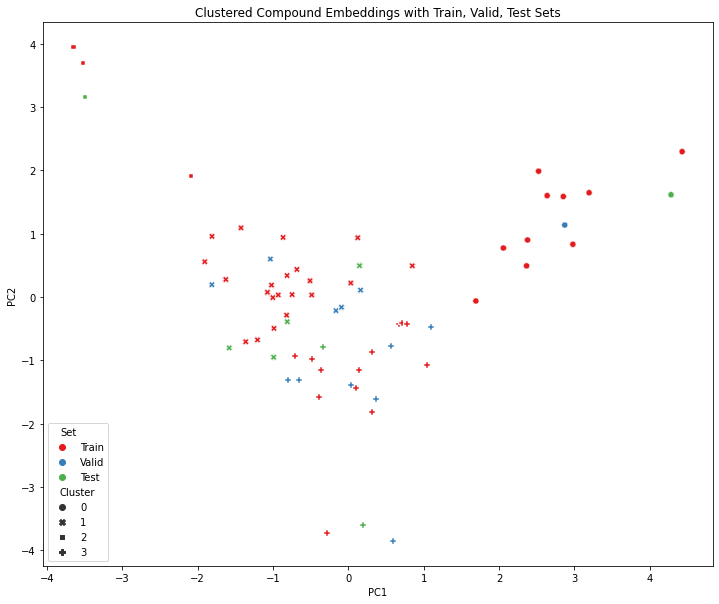

In [16]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


train_fps = get_fingerprints(train_davis['Drug'])
valid_fps = get_fingerprints(valid_davis['Drug'])
test_fps = get_fingerprints(test_davis['Drug'])


pca = PCA(n_components=2)
all_fps = np.vstack([train_fps, valid_fps, test_fps])
reduced_embeddings = pca.fit_transform(all_fps)


num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(reduced_embeddings)


df_plot = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])
df_plot['Set'] = ['Train'] * len(train_fps) + ['Valid'] * len(valid_fps) + ['Test'] * len(test_fps)
df_plot['Cluster'] = clusters


plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Set', style='Cluster', palette='Set1')
plt.title('Clustered Compound Embeddings with Train, Valid, Test Sets')
plt.show()


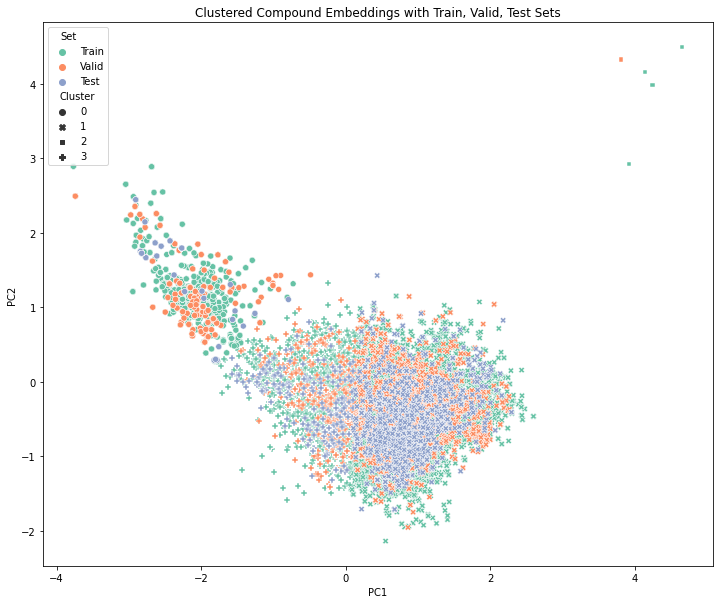

In [17]:
train_fps = get_fingerprints(train_bindingdb['Drug'])
valid_fps = get_fingerprints(valid_bindingdb['Drug'])
test_fps = get_fingerprints(test_bindingdb['Drug'])


pca = PCA(n_components=2)
all_fps = np.vstack([train_fps, valid_fps, test_fps])
reduced_embeddings = pca.fit_transform(all_fps)


num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(reduced_embeddings)


df_plot = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])
df_plot['Set'] = ['Train'] * len(train_fps) + ['Valid'] * len(valid_fps) + ['Test'] * len(test_fps)
df_plot['Cluster'] = clusters


plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Set', style='Cluster', palette='Set2')
plt.title('Clustered Compound Embeddings with Train, Valid, Test Sets')
plt.show()


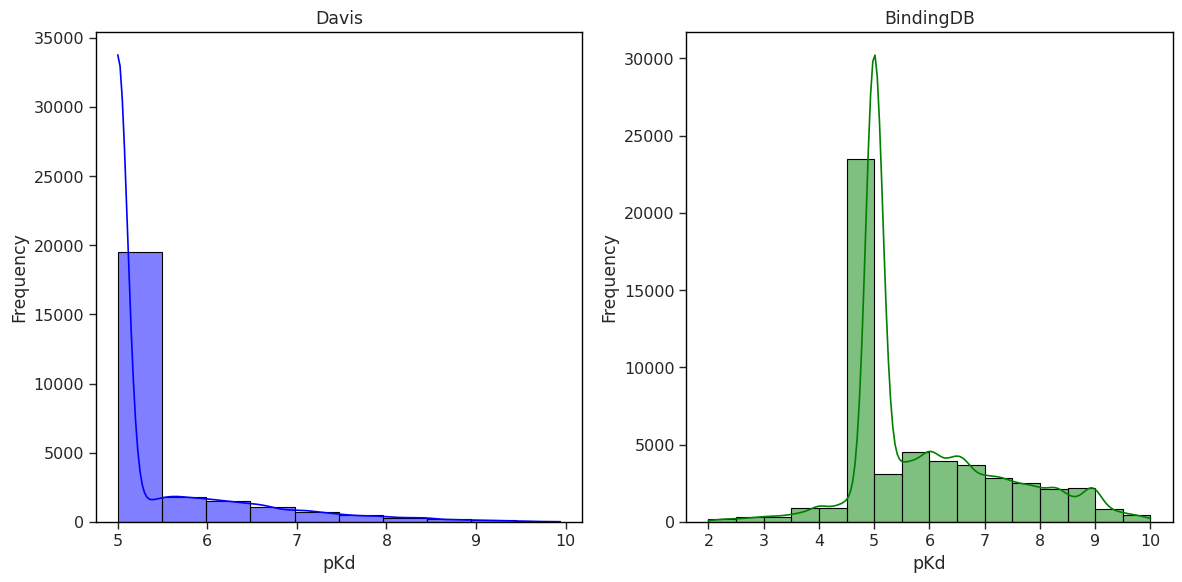

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_context("paper", font_scale=1.3)

plt.figure(figsize=(12, 6))

# Davis dataset
plt.subplot(1, 2, 1) 
sns.histplot(df['Y'], kde=True, color='blue', binwidth=0.5)
plt.title('Davis')
plt.xlabel('pKd')
plt.ylabel('Frequency')

# BindingDB dataset
plt.subplot(1, 2, 2) 
sns.histplot(df1['Y'], kde=True, color='green', binwidth=0.5)
plt.title('BindingDB')
plt.xlabel('pKd')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


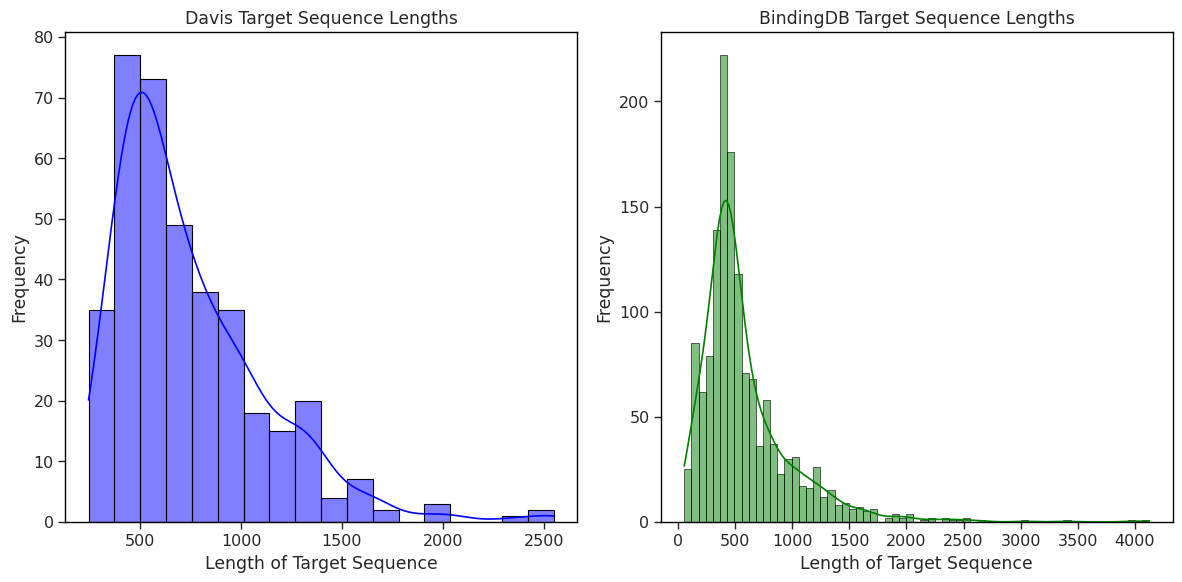

In [32]:
unique_targets_davis = df['Target'].unique()
unique_targets_bindingdb = df1['Target'].unique()
unique_target_lengths_davis = [len(target) for target in unique_targets_davis]
unique_target_lengths_bindingdb = [len(target) for target in unique_targets_bindingdb]

plt.figure(figsize=(12, 6))

# Davis dataset
plt.subplot(1, 2, 1)
sns.histplot(unique_target_lengths_davis, kde=True, color='blue')
plt.title('Davis Sequence Lengths')
plt.xlabel('Length of Sequence')
plt.ylabel('Frequency')

# BindingDB dataset
plt.subplot(1, 2, 2)
sns.histplot(unique_target_lengths_bindingdb, kde=True, color='green')
plt.title('BindingDB Sequence Lengths')
plt.xlabel('Length of Sequence')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### Loading ESM and Chemberta embeddings

In [ ]:
# Load ESM Model
esm_tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")
esm_model = AutoModel.from_pretrained("facebook/esm2_t12_35M_UR50D")

# Load ChemBERTa Model
chemberta_tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
chemberta_model = AutoModel.from_pretrained("DeepChem/ChemBERTa-77M-MTR")

In [ ]:
def get_embeddings(model, tokenizer, sequences):
    embeddings = []
    for seq in sequences:
        inputs = tokenizer(seq, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state
        embedding = torch.mean(last_hidden_states, dim=1).squeeze().numpy()
        embeddings.append(embedding)
    return embeddings

In [ ]:
# Davis
drug_embeddings = get_embeddings(chemberta_model, chemberta_tokenizer, unique_drugs)
target_embeddings = get_embeddings(esm_model, esm_tokenizer, unique_targets)


embeddings_dict = {"Drug_ID": df['Drug_ID'].unique(), "Drug_Embedding": drug_embeddings,
                   "Target_ID": df['Target_ID'].unique(), "Target_Embedding": target_embeddings}
# Save the embeddings with Drug ID and Target ID
file_path = 'embeddings_davis.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(embeddings_dict, file)
    

# Binding DB
drug_embeddings1 = get_embeddings(chemberta_model, chemberta_tokenizer, unique_drugs1)
target_embeddings1 = get_embeddings(esm_model, esm_tokenizer, unique_targets1)

embeddings_dict1 = {"Drug_ID": df['Drug_ID'].unique(), "Drug_Embedding": drug_embeddings1,
                   "Target_ID": df['Target_ID'].unique(), "Target_Embedding": target_embeddings1}




In [21]:
# Load the dictionary using pickle
file_path = 'embeddings_davis.pkl'
with open(file_path, 'rb') as file:
    embeddings_dict  = pickle.load(file)

In [22]:
file_path = 'embeddings_bindingdb.pkl'
with open(file_path, 'rb') as file:
    embeddings_dict1  = pickle.load(file)

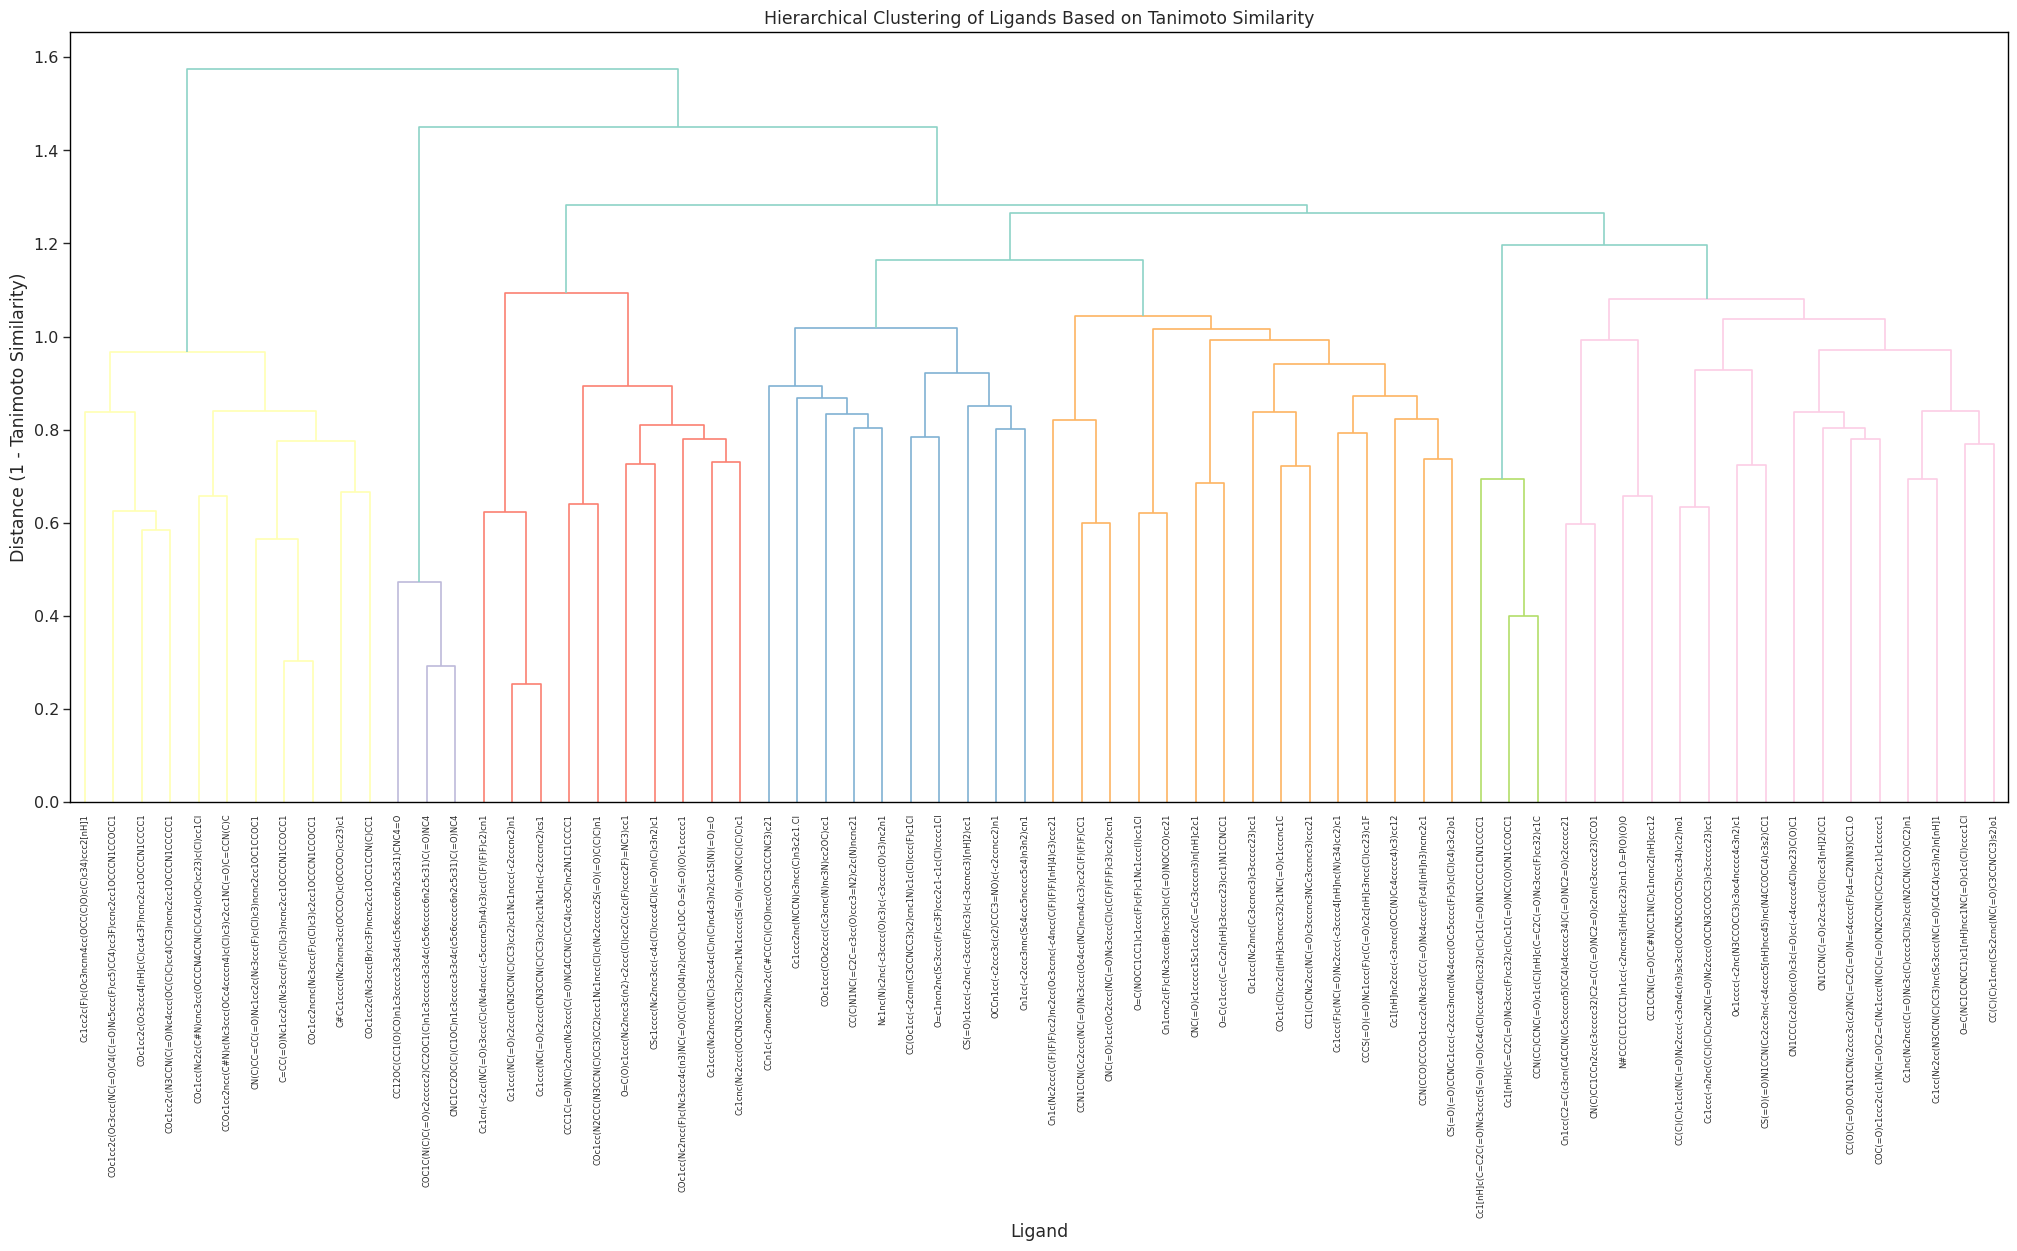

In [56]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram


smiles_list = unique_drugs

# Generate fingerprints and convert them to NumPy arrays
fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), radius=2, nBits=1024) for smile in smiles_list]
np_fps = np.zeros((len(fps), len(fps[0]))) 

for i, fp in enumerate(fps):
    DataStructs.ConvertToNumpyArray(fp, np_fps[i])

# Tanimoto similarity function
def tanimoto_similarity(fp1, fp2):
    return np.dot(fp1, fp2) / (np.sum(fp1) + np.sum(fp2) - np.dot(fp1, fp2))

# Calculate pairwise distances
distances = pdist(np_fps, lambda fp1, fp2: 1 - tanimoto_similarity(fp1, fp2))

# Perform hierarchical clustering
Z = linkage(distances, 'ward')

# Plot dendrogram
plt.figure(figsize=(25, 10))
dendrogram(Z, labels=smiles_list, leaf_rotation=90.)
plt.title('Hierarchical Clustering of Ligands Based on Tanimoto Similarity')
plt.xlabel('Ligand')
plt.ylabel('Distance (1 - Tanimoto Similarity)')
plt.show()


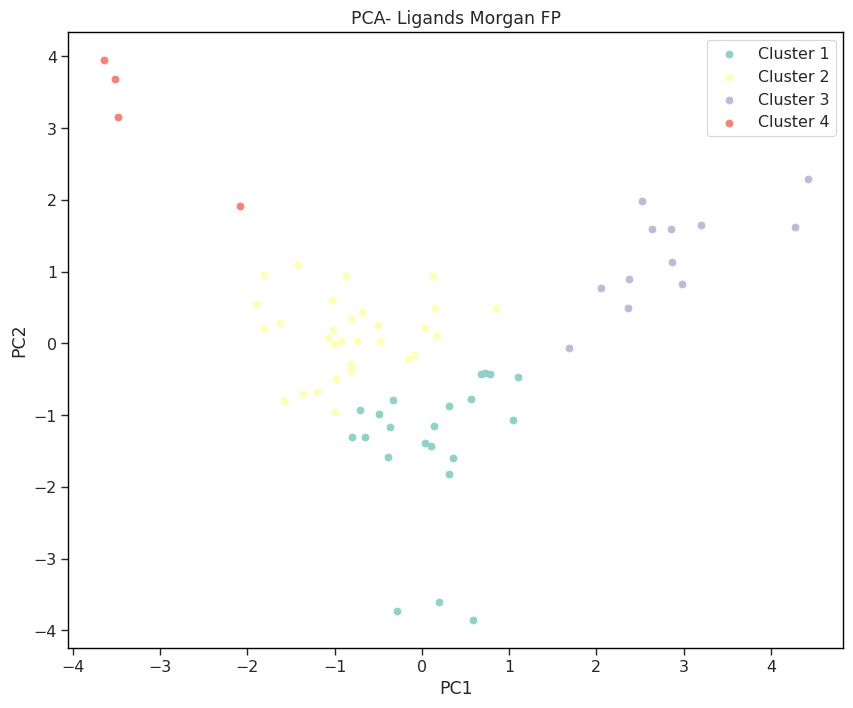

In [57]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(np_fps)


num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(reduced_embeddings)


plt.figure(figsize=(10, 8))
sns.set_palette("Set3")
for i in range(num_clusters):
    # Select only data points that belong to the current cluster
    cluster_points = reduced_embeddings[clusters == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA- Ligands Morgan FP')
plt.legend()
plt.show()


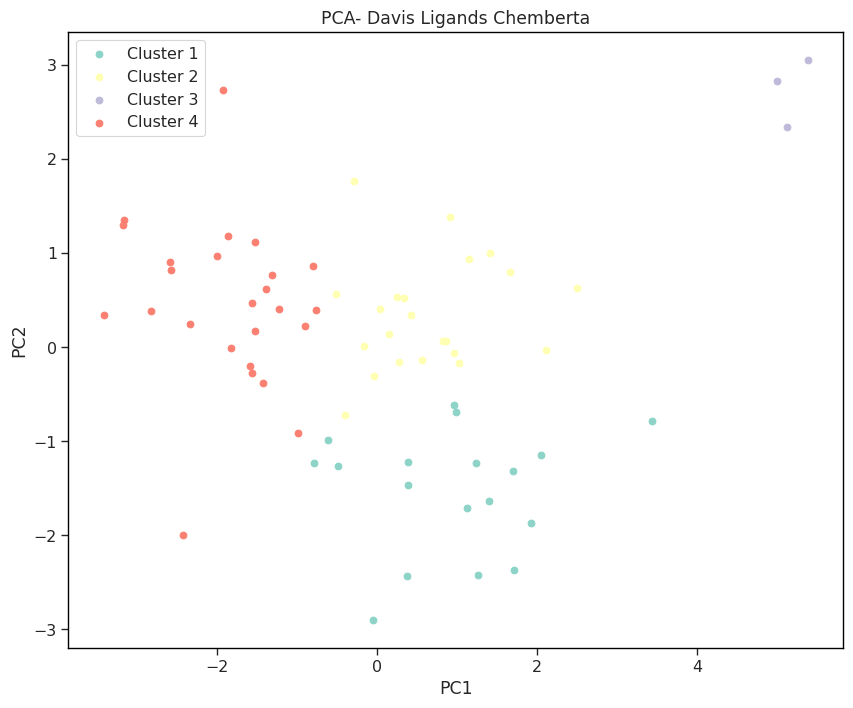

In [58]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_dict['Drug_Embedding'])


num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(reduced_embeddings)


plt.figure(figsize=(10, 8))
sns.set_palette("Set3")
for i in range(num_clusters):
    # Select only data points that belong to the current cluster
    cluster_points = reduced_embeddings[clusters == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA- Davis Ligands Chemberta')
plt.legend()
plt.show()


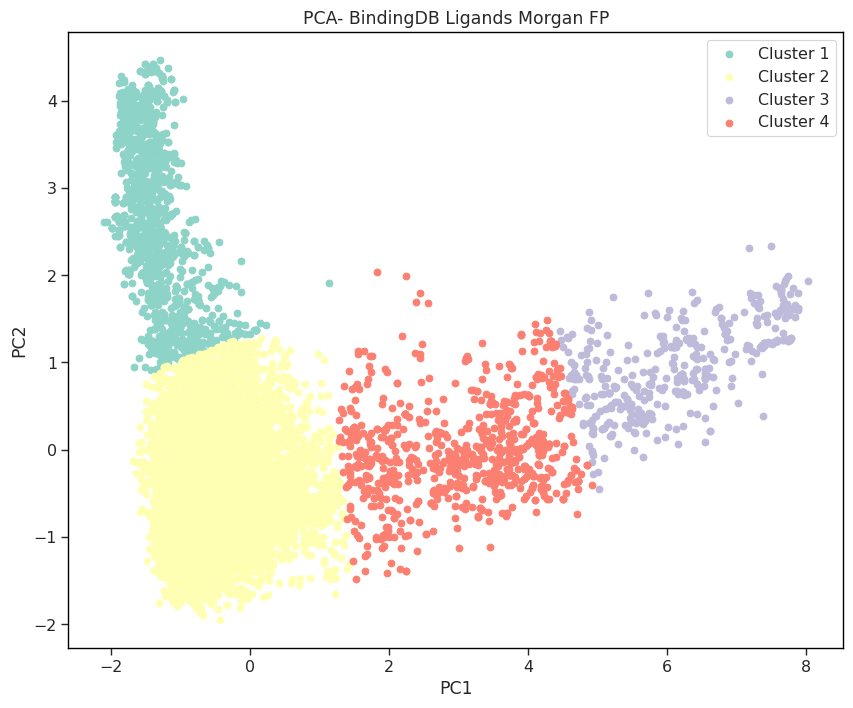

In [54]:
smiles_list = unique_drugs1

# Generate fingerprints and convert them to NumPy arrays
fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), radius=2, nBits=1024) for smile in smiles_list]
np_fps = np.zeros((len(fps), len(fps[0])))  # Initialize a NumPy array of the correct size

for i, fp in enumerate(fps):
    DataStructs.ConvertToNumpyArray(fp, np_fps[i])
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(np_fps)


num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(reduced_embeddings)

plt.figure(figsize=(10, 8))
sns.set_palette("Set3")
for i in range(num_clusters):
    # Select only data points that belong to the current cluster
    cluster_points = reduced_embeddings[clusters == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA- BindingDB Ligands Morgan FP')
plt.legend()
plt.show()


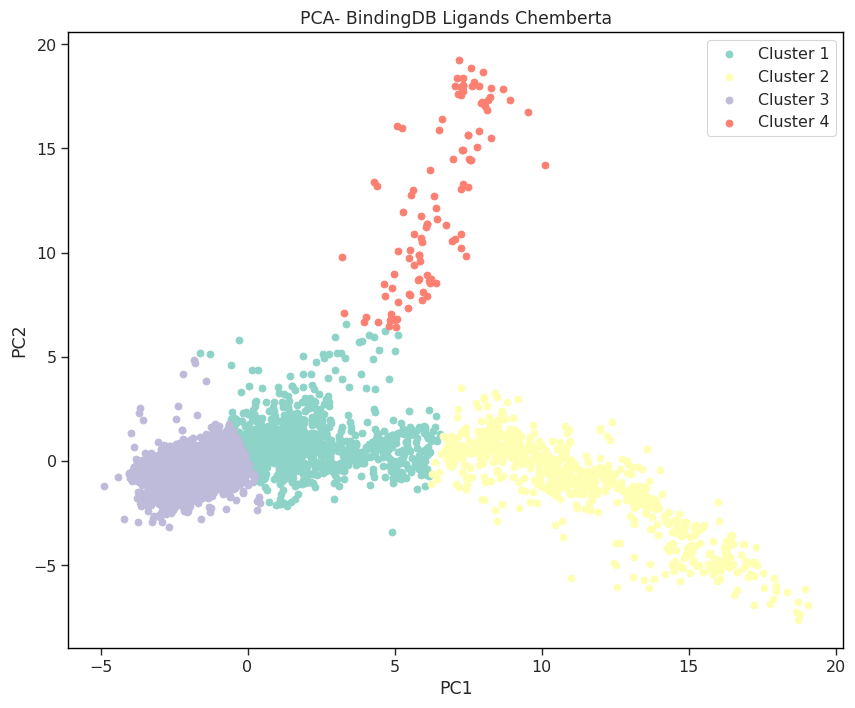

In [53]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_dict1['Drug_Embedding'])


num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(reduced_embeddings)

# Step 3: Plot with colors
plt.figure(figsize=(10, 8))
sns.set_palette("Set3")
for i in range(num_clusters):
    # Select only data points that belong to the current cluster
    cluster_points = reduced_embeddings[clusters == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA- BindingDB Ligands Chemberta')
plt.legend()
plt.show()


### Proteins Comparision

In [51]:
target_id_mapping_davis = dict(zip(df['Target'], df['Target_ID']))
target_id_mapping_bindingdb = dict(zip(df1['Target'], df1['Target_ID']))

common_target_ids = [target_id_mapping_davis[protein] for protein in common_proteins if protein in target_id_mapping_davis]
print("Common Target IDs:", common_target_ids)
print(f"Number of common proteins: {len(common_target_ids)}")

Common Target IDs: ['CSNK1G3', 'CSNK1A1', 'NEK2', 'SNRK', 'PIP5K1A', 'EPHA2', 'ERK4', 'PDGFRA', 'YANK1', 'AMPK-alpha1', 'MELK', 'TNK1', 'HPK1', 'PRKD1', 'AKT3', 'MAPKAPK5', 'ULK2', 'LKB1', 'p38-beta', 'PKMYT1', 'PKAC-beta', 'MEK6', 'CSNK2A1', 'STK33', 'ROS1', 'MEK5', 'STK36', 'TAOK1', 'AURKB', 'CAMK1', 'MST1', 'PIM2', 'MAP3K2', 'AURKC', 'CAMK2B', 'CAMK1D', 'TAOK3', 'BRSK1', 'SNARK', 'CSNK1E', 'RAF1', 'ZAK', 'FES', 'ERBB2', 'MYO3B', 'CDK2', 'MYO3A', 'PRKCE', 'CDK5', 'MAK', 'MAP4K3', 'PCTK2', 'CDK4-cyclinD3', 'FGFR1', 'ACVR2A', 'HIPK2', 'RIOK3', 'NDR2', 'NDR1', 'RIOK1', 'GSK3A', 'DYRK1A', 'HIPK1', 'MRCKB', 'S6K1', 'RIOK2', 'MAP3K15', 'PLK2', 'SgK110', 'TSSK1B', 'MAP4K2', 'JNK3', 'CTK', 'CSNK1A1L', 'MAP3K1', 'ULK3', 'KIT(V559D-V654A)', 'ARK5', 'LIMK1', 'PIK3CD', 'SRPK3', 'QSK', 'BRAF(V600E)', 'MAP3K3', 'AMPK-alpha2', 'AKT2', 'MLCK', 'YANK2', 'FER', 'DCAMKL2', 'TGFBR2', 'FGFR4', 'CAMK2A', 'GSK3B', 'MARK3', 'PIP5K1C', 'PDPK1', 'PRKG1', 'NLK', 'EPHB6', 'JAK2(JH1domain-catalytic)', 'TEC', 'CD

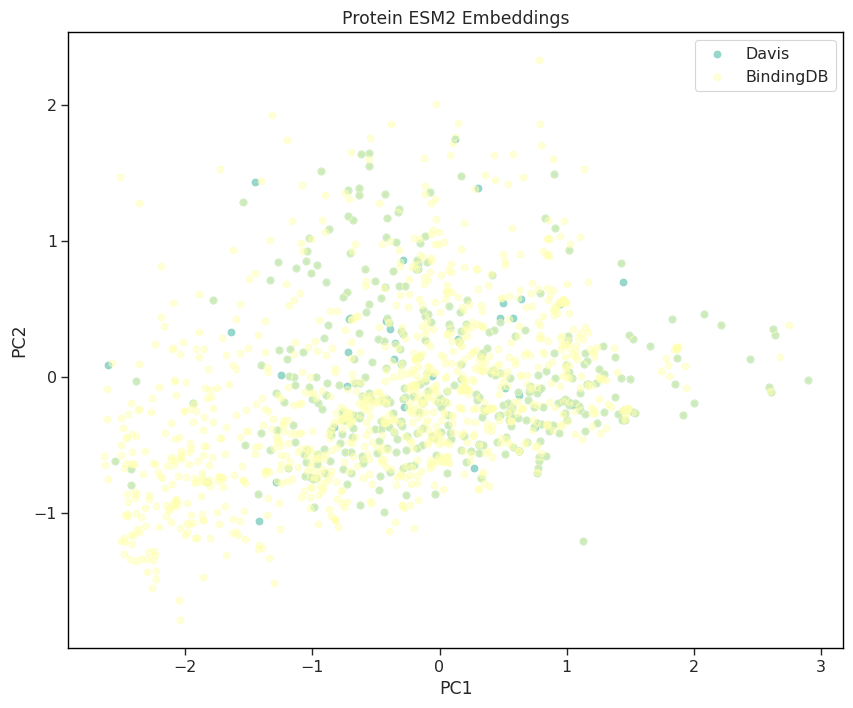

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np


davis_embeddings = np.array(embeddings_dict['Target_Embedding'])
bindingdb_embeddings = np.array(embeddings_dict1['Target_Embedding'])


pca = PCA(n_components=2)
reduced_davis = pca.fit_transform(davis_embeddings)
reduced_bindingdb = pca.transform(bindingdb_embeddings)

# Plot
plt.figure(figsize=(10, 8))
sns.set_palette("Set3")

# Plot Davis embeddings
plt.scatter(reduced_davis[:, 0], reduced_davis[:, 1], alpha=0.9, label='Davis')

# Plot BindingDB embeddings
plt.scatter(reduced_bindingdb[:, 0], reduced_bindingdb[:, 1], alpha=0.5, label='BindingDB')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Protein ESM2 Embeddings' )
plt.legend()
plt.show()


In [61]:

davis_embeddings = np.array(embeddings_dict['Target_Embedding'])
bindingdb_embeddings = np.array(embeddings_dict1['Target_Embedding'])


combined_embeddings = np.vstack((davis_embeddings, bindingdb_embeddings))

num_clusters = 3  
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(combined_embeddings)


labels = np.array(['Davis'] * len(davis_embeddings) + ['BindingDB'] * len(bindingdb_embeddings))

# Count the number of proteins from each dataset in each cluster
for i in range(num_clusters):
    cluster_labels = labels[clusters == i]
    count_davis = np.sum(cluster_labels == 'Davis')
    count_bindingdb = np.sum(cluster_labels == 'BindingDB')
    print(f"Cluster {i+1}: Davis - {count_davis}, BindingDB - {count_bindingdb}")

    

Cluster 1: Davis - 102, BindingDB - 544
Cluster 2: Davis - 277, BindingDB - 641
Cluster 3: Davis - 0, BindingDB - 228


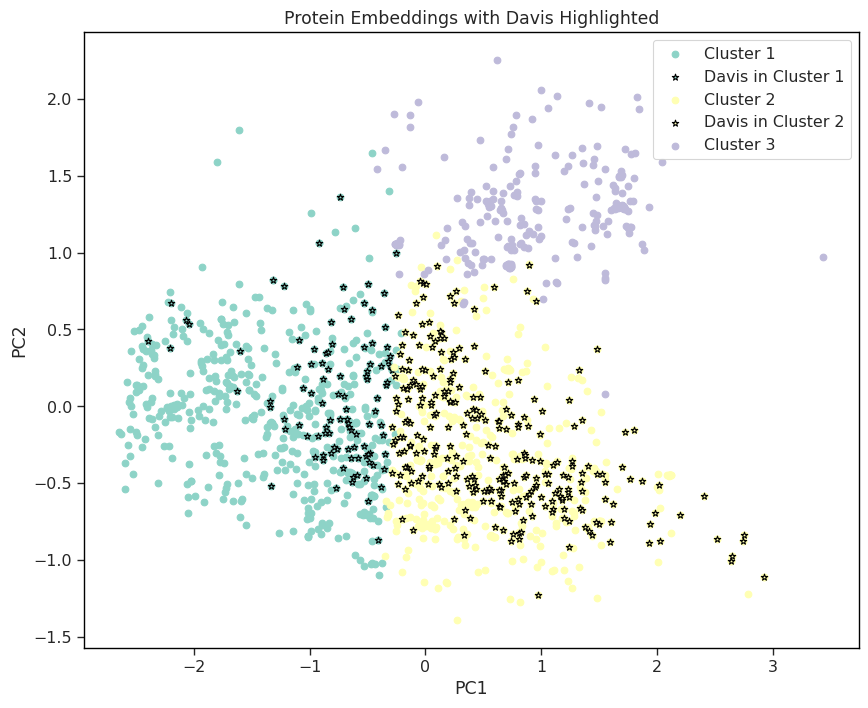

In [63]:


import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(combined_embeddings)

davis_indices = np.arange(len(davis_embeddings))
bindingdb_indices = np.arange(len(davis_embeddings), len(davis_embeddings) + len(bindingdb_embeddings))

plt.figure(figsize=(10, 8))
colors = sns.color_palette('Set3')


for i in range(num_clusters):

    cluster_points = reduced_embeddings[clusters == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[i], label=f'Cluster {i+1}')

    davis_in_cluster = davis_indices[np.isin(davis_indices, np.where(clusters == i)[0])]
    

    if len(davis_in_cluster) > 0:
        davis_cluster_points = reduced_embeddings[davis_in_cluster]
        plt.scatter(davis_cluster_points[:, 0], davis_cluster_points[:, 1], c=colors[i], edgecolor='black', marker='*', label=f'Davis in Cluster {i+1}')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Protein Embeddings with Davis Highlighted')
plt.legend()
plt.show()
